# Intro timeseries

## A. Init

1.   Install required packages
2.   Functions



### A.1 Install required packages

In [1]:
!pip install prophet pmdarima > /dev/null 2>&1

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf

from IPython.display import display, HTML


### A.2 Functions

In [3]:
# split data frame in validate and train set, based on input date
def split_train_validate(df, date_column="date", hist_end=pd.Timestamp("2015-12")):
    df['train_data'] = np.where(df[date_column] <= hist_end, 1, 0)
    df_validate = df[df['train_data'] == 0]
    df_train = df[df['train_data'] == 1]
    return df_train, df_validate, df

def produce_metrics(pd_pred: pd.DataFrame, y='y', res='res'):
    """
    Calculates a number of metrics given data with residuals and actual values.
    :param pd_pred: pandas Dataframe with at least residuals and actual values.
    :return: a tuple of metrics
    """

    e = (pd_pred.loc[:, res]).dropna()
    value = pd_pred.loc[:, y].dropna()
    se = np.square(e)
    ae = np.abs(e)

    bias = np.mean(e)
    rmse = np.sqrt(np.mean(se))
    mae = np.mean(ae)
    mean_value = np.mean(value)
    mae_perc = mae/mean_value*100
    rmse_perc = rmse/mean_value*100

    return {"mean_value": mean_value, "bias": bias, "rmse": rmse, 
            "rmse_perc": rmse_perc, "mae": mae, "mae_perc": mae_perc}

def plot_residuals(pd_res: pd.DataFrame) -> go.Figure:
    """
    Create summary residual plot of all predictions
    """

    pd_res = pd_res.sort_values(['date'])
    ae = np.abs((pd_res.loc[:, 'res']).dropna())
    datetime_validation = min(pd_res[pd_res.train_data == 0]['date'])

    fig = make_subplots(rows=2, cols=1)

    fig.add_trace(
        go.Scattergl(x=pd_res['date'], y=pd_res['res'], mode='markers'),
        row=1, col=1
    )
    fig.add_shape(type='line',
                  x0=datetime_validation,
                  y0=min(pd_res['res']),
                  x1=datetime_validation,
                  y1=max(pd_res['res']),
                  line=dict(color='White', ),
                  col=1,
                  row=1
                  )
    fig.add_trace(
        go.Scattergl(x=pd_res['yhat'], y=pd_res['res'], mode='markers'),
        row=2, col=1
    )
    fig.add_shape(type='line',
                  x0=datetime_validation,
                  y0=min(pd_res['res']),
                  x1=datetime_validation,
                  y1=max(pd_res['res']),
                  line=dict(color='White', ),
                  col=1,
                  row=1
                  )
    fig.update_yaxes(title='RESIDUAL (ACTUAL - PREDICTED)', col=1, row=1)
    fig.update_yaxes(title='RESIDUAL (ACTUAL - PREDICTED)', col=1, row=2)
    fig.update_xaxes(title='TIME', col=1, row=1)
    fig.update_xaxes(title='TEMPERATURE ANOMALY', col=1, row=2)

    fig.update_layout(template="plotly_dark", height=800, showlegend=False)

    return fig

## B - Case global temperature anomalies



### B.1 Load data

This data is about temperature anomalies since 1880. More information can be found here: https://datahub.io/core/global-temp

It's important to note that these numbers are no absolute temperatures, but anomalies compared to a baseline:

- GISTEMP base period: 1951-1980 (anomalies = deviations from the corresponding 1951-1980 means)
- GCAG base period: 20th century average.

In [4]:
!mkdir -p data
!wget -O data/data.csv https://datahub.io/core/global-temp/r/monthly.csv
#data comes from: https://datahub.io/core/global-temp

--2021-11-09 21:30:43--  https://datahub.io/core/global-temp/r/monthly.csv
Resolving datahub.io (datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3030::ac43:9d26, ...
Connecting to datahub.io (datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/core/global-temp/monthly_csv/data/c1321100952fc1b643ec604ae65a104a/monthly_csv.csv [following]
--2021-11-09 21:30:44--  https://pkgstore.datahub.io/core/global-temp/monthly_csv/data/c1321100952fc1b643ec604ae65a104a/monthly_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82182 (80K) [text/csv]
Saving to: ‘data/data.csv’

data/data.csv       100%[===================>]  80.26K  --.-KB/s    in 0.008s  

2021-11-09 21:30:44 (9.36 MB/s) - ‘data/data.

### B.2 Prepare data

- parse date column to a pandas datetime type
- fix set month date to first day of the month (easier to handle)
- add some month / year columns

In [5]:
# read data
df_temp = pd.read_csv("data/data.csv")

# filter data, drop and rename columns
df_temp = (
    df_temp
    [df_temp["Source"] == "GISTEMP"]
    .drop(columns="Source")
    .rename(columns={
        "Mean": "temperature",
        "Date": "date",
    })
    .sort_values("date")
)

# add day and time variables
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["year"] = df_temp["date"].dt.year
df_temp["month"] = df_temp["date"].dt.month
df_temp["month_name"] = df_temp["date"].dt.strftime("%b")
df_temp["date_name"] = df_temp["date"].dt.strftime("%Y-%m")
df_temp = df_temp[["date", "date_name", "year", "month", "month_name", "temperature"]]

# show first 3 rows of data
df_temp.head(3)

,date,date_name,year,month,month_name,temperature
3287,1880-01-06,1880-01,1880,1,Jan,-0.30
3285,1880-02-06,1880-02,1880,2,Feb,-0.21
3283,1880-03-06,1880-03,1880,3,Mar,-0.18


### B.3 Explore by visualization

The first thing to do (in any data analysis task) is to plot the data. Graphs enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables.

Some important questions to consider when first looking at a time series are:

- Trend? Do measurements tend to increase (or decrease) over time?
- Seasonality? Is there a regularly repeating pattern related to calendar time?
- Cycle? Is there a long-run cycle or period unrelated to seasonality factors?
- Outliers? Are there points far away from other data?
- Variance? Constant over time or non-constant?
- Abrupt changes?

#### Trend & outliers

##### Line plot

In [6]:
fig = px.line(
    df_temp,
    x="date_name",
    y="temperature",
    title='Monthly average temperature anomalie in °C relative to a base period (1951-1980)',
)
fig.update_xaxes(title='Date (month)')
fig.update_yaxes(title='Temperature anomalie (°C)')
fig.update_layout(template="plotly_dark", height=400, showlegend=True)
fig.show()


fig = px.scatter(
    df_temp,
    x="date_name",
    y="temperature",
    title='Monthly average temperature anomalie in °C relative to a base period (1951-1980)',
)
fig.update_xaxes(title='Date (month)')
fig.update_yaxes(title='Temperature anomalie (°C)')
fig.update_layout(template="plotly_dark", height=400, showlegend=True)
fig.show()

##### Bar plot
- Too many bars to plot => filter data on recent years
- or average on year to see trend

In [ ]:
fig = px.bar(
    df_temp[df_temp.year>1970],
    x="date_name",
    y="temperature",
    color='temperature',
    color_continuous_scale=px.colors.sequential.RdBu_r,
    color_continuous_midpoint=0,
    title='Monthly average temperature anomalie in °C relative to a base period (1951-1980)',
)
fig.update_xaxes(title='Date (month)')
fig.update_yaxes(title='Temperature anomalie (°C)')
fig.update_layout(template="plotly_dark", width=1500, showlegend=True)
fig.show()

In [7]:
#yearly average
df_temp_yearly = df_temp[['year', 'temperature']].groupby('year').agg('mean').reset_index()

fig = px.bar(
    df_temp_yearly,
    x="year",
    y="temperature",
    color='temperature',
    color_continuous_scale=px.colors.sequential.RdBu_r,
    color_continuous_midpoint=0,
    title='Yearly average temperature anomalie in °C relative to a base period (1951-1980)',
)
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Temperature anomalie (°C)')
fig.update_layout(template="plotly_dark", width=1000, showlegend=True)
fig.show()

##### Conclusion
- Increasing trend from mid ninenteens on
- No 'one' linear trend
- No visible extreme outliers
- No visible seasonalities. !the data data consists of deviations of a base temperature, which means that the usual seasonalities like winter vs summers are not present here.

#### Seasonalities & cycle period

##### Seasonality plot

In [ ]:
fig = px.line_polar(
    df_temp[df_temp["year"] > 2006],
    r="temperature",
    theta="month_name",
    color="year",
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    line_close=True,
    title='Monthly average temperature anomalie in °C relative to a base period (1951-1980)'
)
fig.update_layout(template="plotly_dark", height=600, width=800, showlegend=True)
fig.show()

##### Lag plot
Plot the values against the values k-shifts back. It can show if there is any and the nature of the correlation with the previous values.

In [ ]:
def lag_plot(ts, lag):
  fig = go.Scatter(
    x=ts[:-lag],
    y=ts[lag:],
    mode='markers'
  )
  return fig

Lags = [1,2,3,4,5,6,13,14,15]

fig = make_subplots(rows=3, cols=3, 
                    subplot_titles=[f'Lag {i}' for i in Lags])

for i in range(1, len(Lags)+1):
  row_num = 1+int((i-1)/3)
  col_num = (2+i)%3 + 1
  fig.add_trace(lag_plot(ts=df_temp['temperature'], lag=Lags[i-1]),
      row=row_num, col=col_num
  )
  fig.update_xaxes(title_text=f'Value', row=row_num, col=col_num)
  fig.update_yaxes(title_text=f'Value lag {i}', row=row_num, col=col_num)

fig.update_layout(template="plotly_dark", height=1200, showlegend=False)
fig.show()

##### (Partial) Autocorrelation
- The **autocorrelation at lag k** is the correlation between the observations in a timeseries and the observations in the same timeseries shifted k lags
- The autocorrelation plot shows those autocorrelation for a number of lags
- The **partial autocorrelation** at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
- A partial autocorrelation plot is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.
- Mostly, if there are seasonalities, they are visible in the autocorrelation plots


In [ ]:
df_acf = acf(df_temp["temperature"], nlags=48)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x= np.arange(len(df_acf)),
    y= df_acf,
    name= 'Autocorrelation',
    ))

df_pacf = pacf(df_temp["temperature"], nlags=48)
fig.add_trace(go.Scatter(
    x= np.arange(len(df_pacf)),
    y= df_pacf,
    name= 'Partial autocorrelation',
    ))
fig.update_xaxes(title='Lag')
fig.update_yaxes(title='Correlation')
fig.update_layout(template="plotly_dark", height=400, showlegend=True, title='(Partial) Autocorrelation')
fig.show()

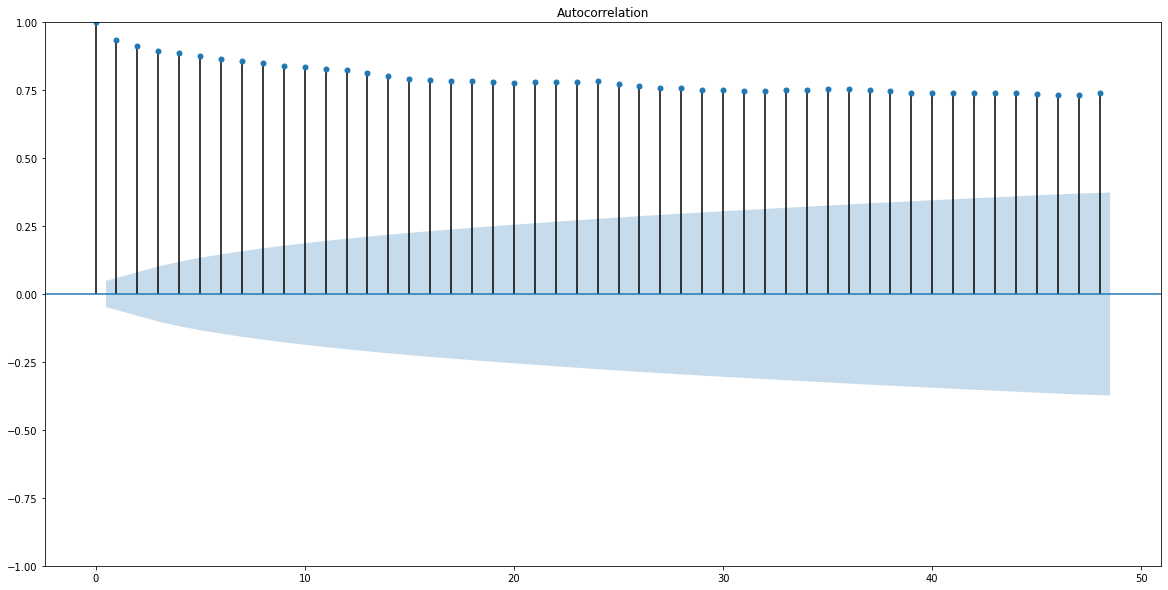

In [ ]:
# Autocorrelation and partial autocorrelation with confidence interval
# Every value outside those boundaries is considered as a correlation significantly different from 0
fig, axs = plt.subplots(1, 1, figsize=(20,10))
plot_acf(df_temp["temperature"], lags=48, ax=axs);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



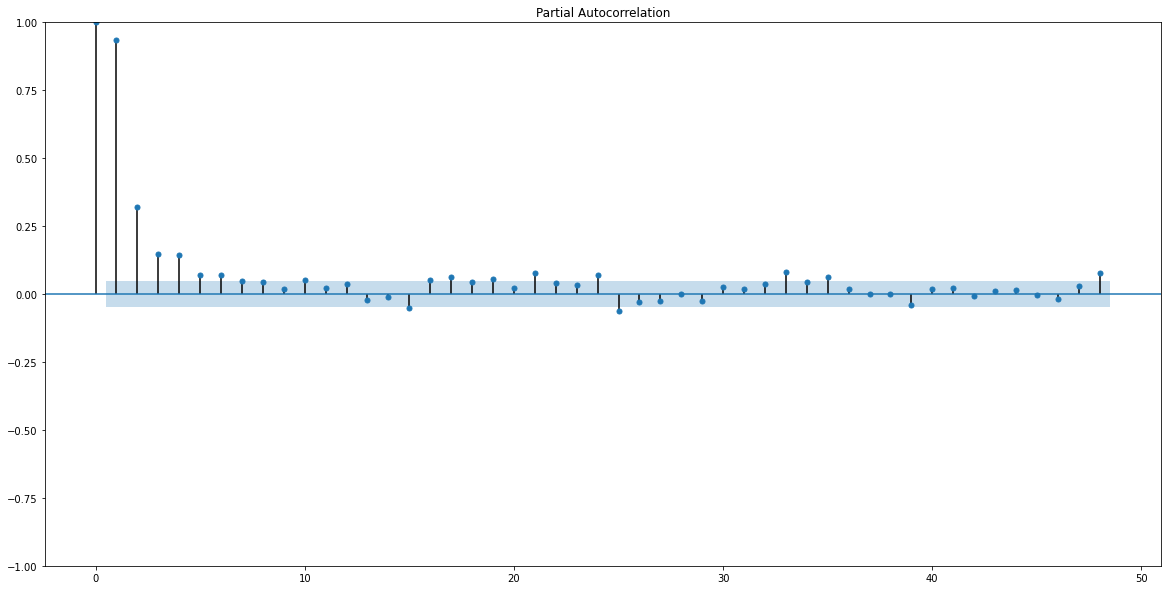

In [ ]:
# Autocorrelation and partial autocorrelation with confidence interval
# Every value outside those boundaries is considered as a correlation significantly different from 0
fig, axs = plt.subplots(1, 1, figsize=(20,10))
plot_pacf(df_temp["temperature"], lags=48, ax=axs);

##### Conclusions
- No clear seasonalities observed 
- Strong correlation with the first (to a lesser degree the second, thirth and fourth) lag. Meaning: the last month could have a high preditive value for the next month  

### B.4 Forecasting

#### Split into train and validaton data
Generally, a dataset is split into a train, validate and test set. The train and validate sets are used to train the different models and validate the results of the trained models to choose the best performing model. The test set is then used at the end to give the final performance measure of the choosen model.
Here, as this is only an introduction, we will work with a train and validation data set.
Specifically:
- Everything before 2015 is train data. This is data that we will use to train our forcasting model
- Everything after 2015 is validation data. We will use this part to validate our performance.

In [8]:
df_train, df_validate, df_data = split_train_validate(df_temp, date_column="date", hist_end=pd.Timestamp("2015-01"))
# show the timewindows in the data
display(df_data.agg({"date": ["min", "max", "count"]}) )
display(df_train.agg({"date": ["min", "max", "count"]}) )
display(df_validate.agg({"date": ["min", "max", "count"]}))

,date
min,1880-01-06 00:00:00
max,2016-12-06 00:00:00
count,1644


,date
min,1880-01-06 00:00:00
max,2014-12-06 00:00:00
count,1620


,date
min,2015-01-06 00:00:00
max,2016-12-06 00:00:00
count,24


#### Forecast with prophet

- For this forecast we will use a prophet model. Prophet is a python framework to do forecasts, developped by facebook. You can read more about it here: https://facebook.github.io/prophet/
- Prophet tries to find a long term trend and then some seasonal components. Since we have montly data, we can only have seasonalities based on monthly periods (e.g. half a year, year, ...)
- Prophet requires at least the following two variables in the dataframe
  - ds: timestamp
  - y: the observations

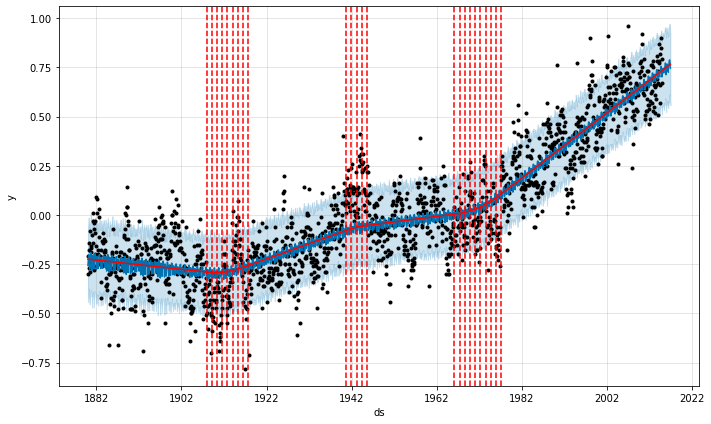

In [ ]:
df_train_prophet = df_train.rename(columns={"date": "ds", "temperature":"y"})
df_data_prophet = df_data.rename(columns={"date": "ds", "temperature":"y"})

params_changepoints = {"n_changepoints": 100, "changepoint_range": 0.9,"changepoint_prior_scale": 0.05}
# n_changepoints: maximum number of possible changepoints for the global trend (model determines how many will be used)
# changepoint_range = % of the datarange where changepoints can be situated
# changepoint_prior_scale: regularization parameter against overfitting, the smaller the less flexible (less changes)

#params_yearly = {"period": 365.25, "fourier_order": 12, "prior_scale": 0.5}
                                
# specify prophet model
model = Prophet(
    **params_changepoints,
    interval_width=0.8, #confidence interval width
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    #seasonality_mode='multiplicative', # change seasonality with trend
    )
# train the model
model.fit(df_train_prophet)

# make future predictions
forecast = model.predict(df_data_prophet)

# plot predictions
fig = plot_plotly(model, forecast)
fig.show()

fig = plot_components_plotly(model, forecast)
fig.show()

from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
display()

#### Validate forecast

- Compare modelbehavior / residuals / metrics between the train data and validation data. 
- Calculate the error of the forecast, which we will average later on. This will show us whether we have bias (like tendancy to over or underestimate)
- Because we have positive and negative errors, it makes sense to also look at the absolute error, which tells you more about how good you can fit the variation over months or cases.

- Both metrics also have a percentual version, where you compare with the actual value to have an indication about how "big" the error is. We will caculate this one on the averaged version to overcome small value problems at record level.

In [ ]:
# join data
df_forecast = pd.merge(
    df_data,
    forecast[["ds", "yhat"]].rename(columns={"ds": "date"}),
    left_on="date",
    right_on="date"
)

# calculate residuals and metrics
df_forecast['res'] = df_forecast['temperature'] - df_forecast['yhat']
produce_metrics(df_forecast[df_forecast.train_data==1], y='temperature', res='res')
produce_metrics(df_forecast[df_forecast.train_data==0], y='temperature', res='res')
pd_results = pd.DataFrame.from_dict(produce_metrics(df_forecast[df_forecast.train_data==1], y='temperature', res='res'), 
                       orient='index', columns=['Train'])
pd_results['Validate'] = pd.DataFrame.from_dict(produce_metrics(df_forecast[df_forecast.train_data==0], y='temperature', res='res'), 
                         orient='index', columns=['Validate'])['Validate']
# show results
pd_results

,Train,Validate
mean_value,0.010981,0.928750
bias,0.000007,0.180070
rmse,0.144038,0.246426
rmse_perc,1311.647613,26.533127
mae,0.114237,0.183172
mae_perc,1040.269842,19.722395


In [ ]:
plot_residuals(df_forecast).show()

#### Conclusions
- The general trend can be estimated with prophet
- However, this is not a good fit. Remaining residuals show a non-random, kind of cyclic behavior, not explainable by the prophet model (which works good in case of strong seasonal effects)
- Either an independent (explaining) variable is missing, or another model taking into account the last few months should be taken into consideration

#### Forecast with auto arima

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

- Auto-Regressive (p) -> Number of autoregressive terms.
- Integrated (d) -> Number of nonseasonal differences needed for stationarity.
- Moving Average (q) -> Number of lagged forecast errors in the prediction equation.

In the Auto ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components. It works similarly like hyper tuning techniques to find the optimal value of p, d, and q with different combinations and the final values would be determined with the lower AIC, BIC parameters taking into consideration.

In [10]:
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

df = df_temp[["date", "temperature"]].copy(deep=True)
df.set_index("date", inplace=True)
display(df)

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

,temperature
date,
1880-01-06,-0.30
1880-02-06,-0.21
1880-03-06,-0.18
1880-04-06,-0.27
1880-05-06,-0.14
...,...
2016-08-06,0.98
2016-09-06,0.87
2016-10-06,0.89


(0.01, False)

In [19]:
model = auto_arima(
    df_train["temperature"].to_numpy(),
    start_p=0,
    d=1,
    start_q=0,
    max_p=1,
    max_d=4,
    max_q=1,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1,
    max_D=1,
    max_Q=1,
    m=12, 
    seasonal=False,
    error_action="warn",
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    random_state=0,
    n_fits=5
)

model.summary()

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2179.976, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2402.516, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2506.761, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2181.928, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2538.145, Time=1.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2539.634, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2508.514, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2404.424, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.112 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1620
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1272.817
Date:                Tue, 09 Nov 2021   AIC                          -2539.634
Time:                        21:40:43   BIC                          -2523.465
Sample:                             0   HQIC                         -2533.633
                               - 1620                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3037      0.037      8.233      0.000       0.231       0.376
ma.L1         -0.7806      0.025    -30.782      0.000      -0.830      -0.731
sigma2         0.0121      0.000     32.310      0.000       0.011       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                33.76
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.18
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# make future predictions
forecast_arima = model.predict(df_validate.shape[0])
df_forecast_arima = df_validate.sort_values('date')
df_forecast_arima['yhat'] = forecast_arima

In [21]:
df_forecast_arima['res'] = df_forecast_arima['temperature'] - df_forecast_arima['yhat']
produce_metrics(df_forecast_arima, y='temperature', res='res')

{'bias': 0.16268799647197016,
 'mae': 0.16994383952831563,
 'mae_perc': 18.29812538662887,
 'mean_value': 0.92875,
 'rmse': 0.23655054761509264,
 'rmse_perc': 25.469776324639852}

# Try it yourself


In [ ]:
# https://machinelearningmastery.com/time-series-datasets-for-machine-learning/
# https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv #shampoo sales
# https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv #minimal temperature for each day in australia
# https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv #sun spots
# https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv female births
# any other dataset you can find!